In [3]:
import pandas as pd
import numpy as np
import os
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks, welch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error, r2_score,mean_absolute_error, root_mean_squared_error

In [4]:
def extract_features(group):
    features = {}
    sensors = ['sensorA', 'sensorB', 'sensorC', 'sensorD']

    for sensor in sensors:
        data = group[sensor]
        
        features[f'{sensor}_mean'] = data.mean()
        features[f'{sensor}_std'] = data.std()
        features[f'{sensor}_min'] = data.min()
        features[f'{sensor}_max'] = data.max()
        features[f'{sensor}_skew'] = skew(data)
        features[f'{sensor}_kurtosis'] = kurtosis(data)
        features[f'{sensor}_energy'] = np.sum(data**2)


    #features['height'] = group['height'].iloc[0]
    features['x'] = group['x'].iloc[0]
    features['y'] = group['y'].iloc[0]

    return pd.Series(features)

In [5]:
simulation = pd.read_csv("simulation_inside_merged.csv")
experiment = pd.read_csv('Impact-events-dataset/merged_dataset.csv', delimiter=';')
experiment.drop(columns = ['sampleNo', 'typeofimpact', 'ID'], inplace = True)
simulation = simulation.rename(columns = {'ID':'experimentNo'})
experiment['x']  = experiment['x']*10
experiment['y']  = experiment['y']*10
print(len(experiment))
print(experiment.head())
print(simulation.head())
features_simulation = simulation.groupby('experimentNo').apply(extract_features).reset_index(drop=True)
features_experiment = experiment.groupby('experimentNo').apply(extract_features).reset_index(drop=True)

sim_X = features_simulation.drop(columns=['x', 'y']) 
sim_y = features_simulation[['x', 'y']] 

exp_X = features_experiment.drop(columns=['x', 'y']) 
exp_y = features_experiment[['x', 'y']] 

#scaler = StandardScaler()

#X_train = scaler.fit_transform(sim_X)
X_train = sim_X
y_train = sim_y  

#X_test = scaler.transform(exp_X) 
X_test = exp_X
y_test = exp_y 

print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Target Shape:", y_train.shape)
print("Testing Target Shape:", y_test.shape)

3855000
   sensorA  sensorB  sensorC  sensorD position      x      y  height  \
0     1788     1796     1789     1783      4_4  223.0  237.0    12.5   
1     1791     1789     1793     1792      4_4  223.0  237.0    12.5   
2     1784     1796     1802     1783      4_4  223.0  237.0    12.5   
3     1792     1795     1778     1789      4_4  223.0  237.0    12.5   
4     1801     1777     1800     1791      4_4  223.0  237.0    12.5   

   experimentNo  
0             1  
1             1  
2             1  
3             1  
4             1  
   Unnamed: 0  sensorA        sensorB       sensorC        sensorD  \
0         502      0.0   0.000000e+00  0.000000e+00   0.000000e+00   
1         503      0.0   0.000000e+00  1.578930e-61   0.000000e+00   
2         504      0.0   0.000000e+00 -8.065814e-10   0.000000e+00   
3         505      0.0 -4.503392e-294 -3.307525e-03   0.000000e+00   
4         506      0.0 -4.435173e-204 -1.980063e-02 -2.227453e-222   

   experimentNo  height    x  

C:\Users\kunal\AppData\Local\Temp\ipykernel_26320\2977664532.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_simulation = simulation.groupby('experimentNo').apply(extract_features).reset_index(drop=True)


Training Features Shape: (419, 28)
Testing Features Shape: (771, 28)
Training Target Shape: (419, 2)
Testing Target Shape: (771, 2)


C:\Users\kunal\AppData\Local\Temp\ipykernel_26320\2977664532.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_experiment = experiment.groupby('experimentNo').apply(extract_features).reset_index(drop=True)


In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

n_estimators = 50
max_depth = 8
max_samples = 280  
n_iterations = 10

mse_X = []
mse_Y = []
mae_X = []
mae_Y = []
r2_X = []
r2_Y = []

for i in range(n_iterations):
    print(f"Iteration {i+1}:")
    
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_samples=max_samples,  
        random_state=i
    )
    
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    mse_x = root_mean_squared_error(y_test['x'], y_pred[:, 0])
    mse_X.append(mse_x)
    
    mse_y = root_mean_squared_error(y_test['y'], y_pred[:, 1])
    mse_Y.append(mse_y)
    
    mae_x = mean_absolute_error(y_test['x'], y_pred[:, 0])
    mae_X.append(mae_x)
    
    mae_y = mean_absolute_error(y_test['y'], y_pred[:, 1])
    mae_Y.append(mae_y)
    
    r2_x = r2_score(y_test['x'], y_pred[:, 0])
    r2_X.append(r2_x)
    
    r2_y = r2_score(y_test['y'], y_pred[:, 1])
    r2_Y.append(r2_y)
    
    print(f"RMSE for x: {mse_x:.4f}, MSE for y: {mse_y:.4f}")
    print(f"MAE for x: {mae_x:.4f}, MAE for y: {mae_y:.4f}")
    print(f"R2 for x: {r2_x:.4f}, R2 for y: {r2_y:.4f}")

average_RMSE_X = np.mean(mse_X)
average_RMSE_Y = np.mean(mse_Y)

average_MAE_X = np.mean(mae_X)
average_MAE_Y = np.mean(mae_Y)

average_R2_X = np.mean(r2_X)
average_R2_Y = np.mean(r2_Y)

print("\nSummary of Metrics:")
print(f"Average RMSE over {n_iterations} iterations for x: {average_RMSE_X:.4f}")
print(f"Average RMSE over {n_iterations} iterations for y: {average_RMSE_Y:.4f}")
print(f"Average MAE over {n_iterations} iterations for x: {average_MAE_X:.4f}")
print(f"Average MAE over {n_iterations} iterations for y: {average_MAE_Y:.4f}")
print(f"Average R2 over {n_iterations} iterations for x: {average_R2_X:.4f}")
print(f"Average R2 over {n_iterations} iterations for y: {average_R2_Y:.4f}")


Iteration 1:
RMSE for x: 75.1271, MSE for y: 76.0256
MAE for x: 63.2787, MAE for y: 64.2487
R2 for x: 0.0478, R2 for y: 0.0501
Iteration 2:
RMSE for x: 72.5413, MSE for y: 74.2689
MAE for x: 61.4950, MAE for y: 61.7979
R2 for x: 0.1122, R2 for y: 0.0935
Iteration 3:
RMSE for x: 74.3279, MSE for y: 73.7505
MAE for x: 62.3870, MAE for y: 62.1832
R2 for x: 0.0680, R2 for y: 0.1061
Iteration 4:
RMSE for x: 72.6119, MSE for y: 78.9547
MAE for x: 60.4636, MAE for y: 65.8312
R2 for x: 0.1105, R2 for y: -0.0245
Iteration 5:
RMSE for x: 74.4995, MSE for y: 75.9450
MAE for x: 61.8355, MAE for y: 63.4732
R2 for x: 0.0637, R2 for y: 0.0521
Iteration 6:
RMSE for x: 70.2614, MSE for y: 74.8033
MAE for x: 59.3874, MAE for y: 62.1167
R2 for x: 0.1672, R2 for y: 0.0804
Iteration 7:
RMSE for x: 73.8215, MSE for y: 75.8188
MAE for x: 62.6128, MAE for y: 63.7806
R2 for x: 0.0806, R2 for y: 0.0553
Iteration 8:
RMSE for x: 70.7598, MSE for y: 73.6401
MAE for x: 58.9719, MAE for y: 61.7591
R2 for x: 0.1553, 

In [44]:
import pywt

def extract_toa_cwt(signal, scales=np.arange(1, 128), wavelet='morl'):
    coeffs, _ = pywt.cwt(signal, scales, wavelet)
    max_scale_idx, max_time_idx = np.unravel_index(np.argmax(np.abs(coeffs)), coeffs.shape)
    
    return max_time_idx

def compute_dtoa(group):

    sensors = ['sensorA', 'sensorB', 'sensorC', 'sensorD']
    toa_results = {}
    
    for sensor in sensors:
        toa_results[sensor] = extract_toa_cwt(group[sensor].values)
    
    dtoa_features = {}
    for i in range(len(sensors)):
        for j in range(i + 1, len(sensors)):
            sensor_i = sensors[i]
            sensor_j = sensors[j]
            dtoa = toa_results[sensor_i] - toa_results[sensor_j]
            key = f"DToA_{sensor_i}_{sensor_j}"
            dtoa_features[key] = dtoa
    
    dtoa_features['height'] = group['height'].iloc[0]
    dtoa_features['x'] = group['x'].iloc[0]
    dtoa_features['y'] = group['y'].iloc[0]
    dtoa_features['experimentNo'] = group['experimentNo'].iloc[0]
    
    return pd.Series(dtoa_features)


def compute_distances_and_filter(df):
    sensor_coordinates = {
        'sensorA': (33,30),
        'sensorB': (33, 287),
        'sensorC': (287,287),
        'sensorD': (287, 30),
    }
    
    valid_rows = []
    
    for index, row in df.iterrows():
        x_impact, y_impact = row['x'], row['y']
        
        distances = {}
        for sensor, (x_sensor, y_sensor) in sensor_coordinates.items():
            distances[sensor] = np.sqrt((x_sensor - x_impact)**2 + (y_sensor - y_impact)**2)
        
        times = {sensor: row[sensor] for sensor in sensor_coordinates.keys()}
        valid = True
        sensors = list(sensor_coordinates.keys())
        
        for i in range(len(sensors)):
            for j in range(i + 1, len(sensors)):
                sensor_i, sensor_j = sensors[i], sensors[j]
                if (times[sensor_i] <= times[sensor_j]) and (distances[sensor_i] > distances[sensor_j]):
                    valid = False
                    break
            if not valid:
                break
        
        if valid:
            valid_rows.append(row)
    
    return pd.DataFrame(valid_rows)


filtered_experiment= compute_distances_and_filter(experiment)

filtered_simulation = compute_distances_and_filter(simulation)
filtered_simulation = filtered_simulation.rename(columns = {'ID':'experimentNo'})


#dtoa_simulation = experiment.groupby('experimentNo').apply(compute_dtoa_with_cwt_group).reset_index(drop=True)
#print(dtoa_simulation.head())


'''
X = features_df.drop(columns=['x', 'y'])  
y = features_df[['x', 'y']]  

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Target Shape:", y_train.shape)
print("Testing Target Shape:", y_test.shape)

'''

'\nX = features_df.drop(columns=[\'x\', \'y\'])  \ny = features_df[[\'x\', \'y\']]  \n\n#scaler = StandardScaler()\n#X_scaled = scaler.fit_transform(X)\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n\nprint("Training Features Shape:", X_train.shape)\nprint("Testing Features Shape:", X_test.shape)\nprint("Training Target Shape:", y_train.shape)\nprint("Testing Target Shape:", y_test.shape)\n\n'

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

def preprocess_signal(signal):
    signal = signal - np.mean(signal) 
    signal = signal / np.max(np.abs(signal))  
    return signal

def extract_toa_peak(signal, sampling_rate=1.0, energy_threshold=0.05):

    signal = preprocess_signal(signal)
    
    energy = np.cumsum(signal**2) / np.sum(signal**2)
    
    toa_index = np.argmax(energy > energy_threshold)
    toa_time = toa_index / sampling_rate
    return toa_time

def compute_dtoa(df, sampling_rate=1.0):
    sensors = ['sensorA', 'sensorB', 'sensorC', 'sensorD']
    toa_results = {sensor: extract_toa_peak(df[sensor].values, sampling_rate) for sensor in sensors}
    
    dtoa_features = {}
    for i in range(len(sensors)):
        for j in range(i + 1, len(sensors)):
            sensor_i = sensors[i]
            sensor_j = sensors[j]
            dtoa = toa_results[sensor_i] - toa_results[sensor_j]
            key = f"DToA_{sensor_i}_{sensor_j}"
            dtoa_features[key] = dtoa
    
    return dtoa_features

def prepare_training_data(df, sampling_rate=1.0):

    dtoa_results = df.groupby('experimentNo').apply(lambda group: pd.Series(compute_dtoa(group, sampling_rate)))
    dtoa_results.reset_index(inplace=True)

    y_train = df.groupby('experimentNo')[['x', 'y']].first().reset_index()  # Target coordinates
    training_data = dtoa_results.merge(y_train, on='experimentNo')
    
    X_train = training_data.drop(columns=['experimentNo', 'x', 'y'])
    y_train = training_data[['x', 'y']]

    return X_train, y_train

X_test, y_test= prepare_training_data(experiment)
X_train, y_train = prepare_training_data(simulation)

C:\Users\kunal\AppData\Local\Temp\ipykernel_26320\2473645616.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dtoa_results = df.groupby('experimentNo').apply(lambda group: pd.Series(compute_dtoa(group, sampling_rate)))
C:\Users\kunal\AppData\Local\Temp\ipykernel_26320\2473645616.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dtoa_results = df.groupby('experimentNo').apply(lambda group: pd.Series(c

In [8]:
print("X_train Sample:")
print(X_train.head())

print("\nY_train Sample:")
print(y_train.head())


X_train Sample:
   DToA_sensorA_sensorB  DToA_sensorA_sensorC  DToA_sensorA_sensorD  \
0                  -2.0                  35.0                  -3.0   
1                 -36.0                 -36.0                 -36.0   
2                   5.0                   4.0                  -8.0   
3                 -15.0                  -3.0                   2.0   
4                 -11.0                  11.0                  17.0   

   DToA_sensorB_sensorC  DToA_sensorB_sensorD  DToA_sensorC_sensorD  
0                  37.0                  -1.0                 -38.0  
1                   0.0                   0.0                   0.0  
2                  -1.0                 -13.0                 -12.0  
3                  12.0                  17.0                   5.0  
4                  22.0                  28.0                   6.0  

Y_train Sample:
     x    y
0  235  240
1   80   80
2  120  200
3  195  120
4  255  140


In [47]:
def process_dataframe(df):
    return df.groupby('experimentNo').apply(compute_dtoa).reset_index(drop=True)

processed_sim = process_dataframe(filtered_simulation)
processed_exp = process_dataframe(filtered_experiment)


X_train = processed_sim[[col for col in processed_sim.columns if col.startswith("DToA")]]
y_train = processed_sim[['x', 'y']]

X_test = processed_exp[[col for col in processed_exp.columns if col.startswith("DToA")]]
y_test = processed_exp[['x', 'y']]

C:\Users\kunal\AppData\Local\Temp\ipykernel_49076\4279430057.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('experimentNo').apply(compute_dtoa).reset_index(drop=True)
C:\Users\kunal\AppData\Local\Temp\ipykernel_49076\4279430057.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('experimentNo').apply(compute_dtoa).reset_index(drop=True)


AttributeError: 'Series' object has no attribute 'columns'

In [9]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(419, 6) (419, 2) (771, 6) (771, 2)


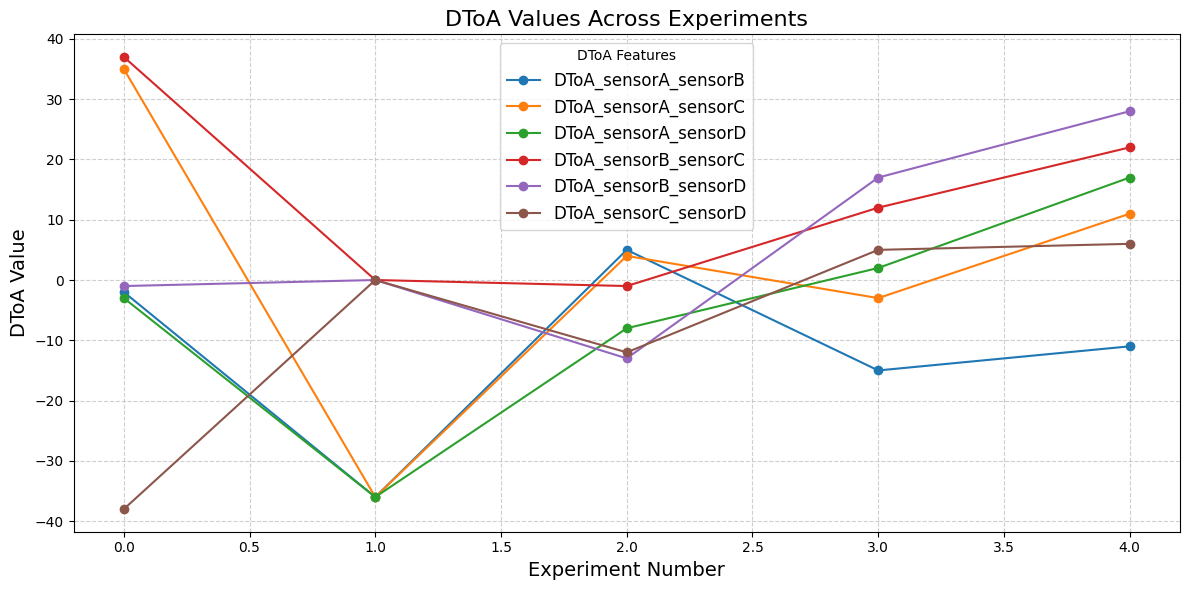

In [58]:
import matplotlib.pyplot as plt

def plot_dtoa(df):

    experiments = df.index 
    dtoa_cols = df.columns  
    
    plt.figure(figsize=(12, 6))
    
    for col in dtoa_cols:
        plt.plot(experiments, df[col], marker='o', label=col)
    
    plt.title('DToA Values Across Experiments', fontsize=16)
    plt.xlabel('Experiment Number', fontsize=14)
    plt.ylabel('DToA Value', fontsize=14)
    plt.legend(title='DToA Features', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    plt.show()


plot_dtoa(X_train[:5])


In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [6, 8, 10, 12],
    'max_samples': [100, 200, 240],
    'min_samples_split': [2, 5, 10, 12],
    'min_samples_leaf': [1, 2, 4, 6]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=3,  
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

y_pred = best_model.predict(X_test)

mse_x = root_mean_squared_error(y_test['x'], y_pred[:, 0])
mae_x = mean_absolute_error(y_test['x'], y_pred[:, 0])
r2_x = r2_score(y_test['x'], y_pred[:, 0])

mse_y = root_mean_squared_error(y_test['y'], y_pred[:, 1])
mae_y = mean_absolute_error(y_test['y'], y_pred[:, 1])
r2_y = r2_score(y_test['y'], y_pred[:, 1])

print(f"Best Model Metrics:")
print(f"RMSE for x: {mse_x:.4f}, RMSE for y: {mse_y:.4f}")
print(f"MAE for x: {mae_x:.4f}, MAE for y: {mae_y:.4f}")
print(f"R2 for x: {r2_x:.4f}, R2 for y: {r2_y:.4f}")

Fitting 3 folds for each of 768 candidates, totalling 2304 fits
Best Parameters: {'max_depth': 12, 'max_samples': 240, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Model Metrics:
RMSE for x: 34.2857, RMSE for y: 36.8832
MAE for x: 25.6341, MAE for y: 29.0506
R2 for x: 0.8017, R2 for y: 0.7764


In [ ]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'estimator__kernel': ['rbf'],  # Limit to RBF initially
    'estimator__C': [1, 10],
    'estimator__epsilon': [0.1, 0.2],
    'estimator__gamma': ['scale']
}

svr = SVR()

multi_output_svr = MultiOutputRegressor(svr)

grid_search = GridSearchCV(
    estimator=multi_output_svr,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=3,  
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

y_pred = best_model.predict(X_test)

mse_x = root_mean_squared_error(y_test['x'], y_pred[:, 0])
mae_x = mean_absolute_error(y_test['x'], y_pred[:, 0])
r2_x = r2_score(y_test['x'], y_pred[:, 0])

mse_y = root_mean_squared_error(y_test['y'], y_pred[:, 1])
mae_y = mean_absolute_error(y_test['y'], y_pred[:, 1])
r2_y = r2_score(y_test['y'], y_pred[:, 1])

print(f"Best Model Metrics:")
print(f"RMSE for x: {mse_x:.4f}, RMSE for y: {mse_y:.4f}")
print(f"MAE for x: {mae_x:.4f}, MAE for y: {mae_y:.4f}")
print(f"R2 for x: {r2_x:.4f}, R2 for y: {r2_y:.4f}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'estimator__C': 10, 'estimator__epsilon': 0.2, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'}
Best Model Metrics:
RMSE for x: 32.2820, RMSE for y: 39.0482
MAE for x: 24.3522, MAE for y: 31.1200
R2 for x: 0.8242, R2 for y: 0.7494


In [51]:
import numpy as np
import pandas as pd

def remove_outliers_iqr(data, threshold):
    data_df = pd.DataFrame(data)
    Q1 = data_df.quantile(0.25)
    Q3 = data_df.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((data_df < (Q1 - threshold * IQR)) | (data_df > (Q3 + threshold * IQR))).any(axis=1)
    data_cleaned = data[mask]
    return data_cleaned, mask

X_test_cleaned, mask = remove_outliers_iqr(X_test, threshold=1.5)
X_train_cleaned, mask1 = remove_outliers_iqr(X_train, threshold=1.5)


y_test_cleaned = y_test[mask]
y_train_cleaned = y_train[mask1]


print(f"Original X_test shape: {X_test.shape}")
print(f"Cleaned X_test shape: {X_test_cleaned.shape}")
print(f"Original X_train shape: {X_train.shape}")
print(f"Cleaned X_train shape: {X_train_cleaned.shape}")


Original X_test shape: (771, 6)
Cleaned X_test shape: (677, 6)
Original X_train shape: (419, 6)
Cleaned X_train shape: (364, 6)


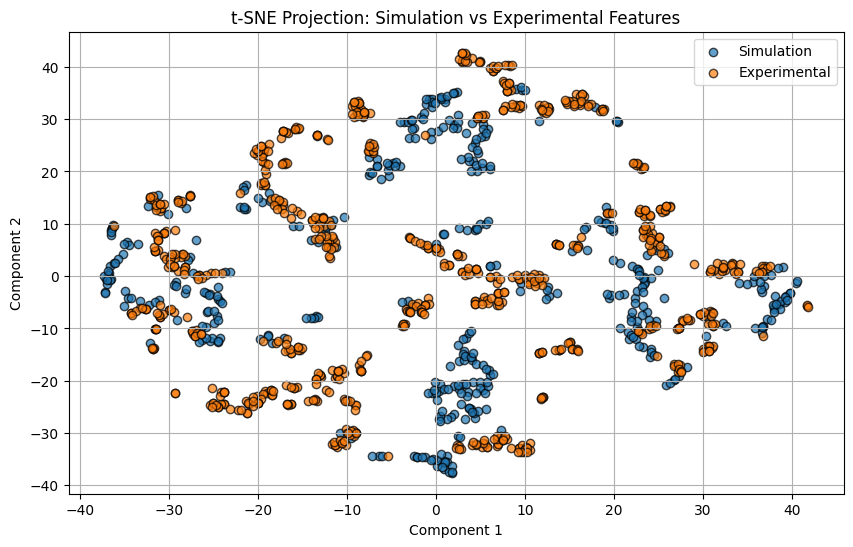

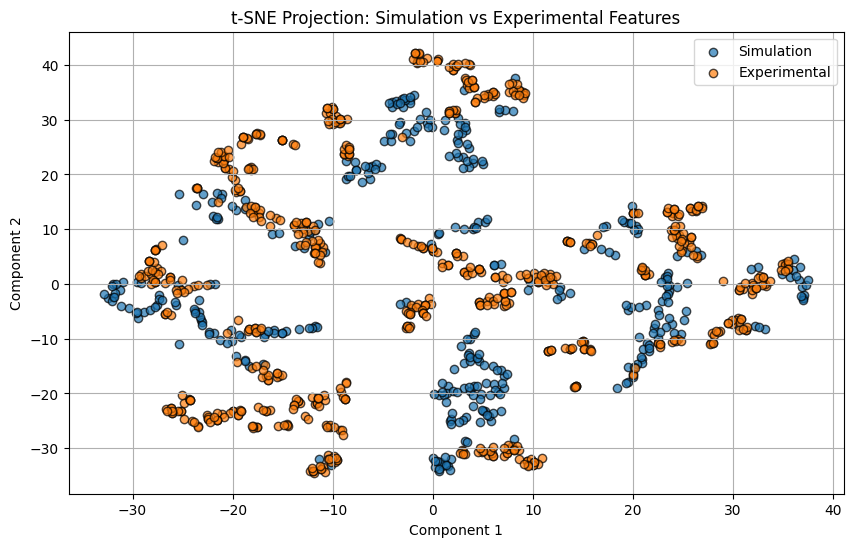

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_data_similarity(X_train, X_test, method='PCA', random_state=42):
    X_combined = np.vstack([X_train, X_test])
    labels = ['Simulation'] * len(X_train) + ['Experimental'] * len(X_test)
    
    if method == 'PCA':
        reducer = PCA(n_components=2, random_state=random_state)
        reduced_data = reducer.fit_transform(X_combined)
        title = "PCA Projection"
    elif method == 't-SNE':
        reducer = TSNE(n_components=2, random_state=random_state, perplexity=30)
        reduced_data = reducer.fit_transform(X_combined)
        title = "t-SNE Projection"
    else:
        raise ValueError("Unsupported method. Use 'PCA' or 't-SNE'.")
    
    plt.figure(figsize=(10, 6))
    for label, color in zip(['Simulation', 'Experimental'], ['blue', 'orange']):
        indices = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(
            reduced_data[indices, 0], reduced_data[indices, 1],
            label=label, alpha=0.7, edgecolor='k'
        )
    
    plt.title(f"{title}: Simulation vs Experimental Features")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_data_similarity(X_train, X_test, method='t-SNE')
visualize_data_similarity(X_train_cleaned, X_test_cleaned, method='t-SNE')



In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [6, 8, 10, 12],
    'max_samples': [100, 200],
    'min_samples_split': [2, 5, 10, 12],
    'min_samples_leaf': [1, 2, 4, 6]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=3,  
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_cleaned, y_train_cleaned)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

y_pred = best_model.predict(X_test_cleaned)

mse_x = root_mean_squared_error(y_test_cleaned['x'], y_pred[:, 0])
mae_x = mean_absolute_error(y_test_cleaned['x'], y_pred[:, 0])
r2_x = r2_score(y_test_cleaned['x'], y_pred[:, 0])

mse_y = root_mean_squared_error(y_test_cleaned['y'], y_pred[:, 1])
mae_y = mean_absolute_error(y_test_cleaned['y'], y_pred[:, 1])
r2_y = r2_score(y_test_cleaned['y'], y_pred[:, 1])

print(f"Best Model Metrics:")
print(f"RMSE for x: {mse_x:.4f}, RMSE for y: {mse_y:.4f}")
print(f"MAE for x: {mae_x:.4f}, MAE for y: {mae_y:.4f}")
print(f"R2 for x: {r2_x:.4f}, R2 for y: {r2_y:.4f}")

Fitting 3 folds for each of 512 candidates, totalling 1536 fits
Best Parameters: {'max_depth': 12, 'max_samples': 100, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best Model Metrics:
RMSE for x: 33.8702, RMSE for y: 39.0467
MAE for x: 26.8739, MAE for y: 32.2449
R2 for x: 0.7613, R2 for y: 0.6715


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cleaned)
X_test_scaled = scaler.transform(X_test_cleaned)

X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='tanh', input_shape=(X_train_cnn.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='tanh'),  # Changed kernel_size to 2
    tf.keras.layers.MaxPooling1D(pool_size=1),  # Changed pool_size to 1
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2)])


model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train_cnn, y_train_cleaned, validation_split=0.2, epochs=100, batch_size=64, verbose=2)

y_pred = model.predict(X_test_cnn)

rmse_x = np.sqrt(mean_squared_error(y_test_cleaned['x'], y_pred[:, 0]))
mae_x = mean_absolute_error(y_test_cleaned['x'], y_pred[:, 0])
r2_x = r2_score(y_test_cleaned['x'], y_pred[:, 0])

rmse_y = np.sqrt(mean_squared_error(y_test_cleaned['y'], y_pred[:, 1]))
mae_y = mean_absolute_error(y_test_cleaned['y'], y_pred[:, 1])
r2_y = r2_score(y_test_cleaned['y'], y_pred[:, 1])

print(f"RMSE for x: {rmse_x:.4f}, RMSE for y: {rmse_y:.4f}")
print(f"MAE for x: {mae_x:.4f}, MAE for y: {mae_y:.4f}")
print(f"R2 for x: {r2_x:.4f}, R2 for y: {r2_y:.4f}")


Epoch 1/100


k:\TUD\WHK2\PINNs\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 - 2s - 315ms/step - loss: 31370.0234 - mae: 159.4204 - val_loss: 30393.6367 - val_mae: 155.9183
Epoch 2/100
5/5 - 0s - 11ms/step - loss: 31190.7500 - mae: 158.9414 - val_loss: 30064.2676 - val_mae: 155.0040
Epoch 3/100
5/5 - 0s - 11ms/step - loss: 30636.2578 - mae: 157.4300 - val_loss: 29084.3672 - val_mae: 152.2114
Epoch 4/100
5/5 - 0s - 13ms/step - loss: 29152.3301 - mae: 153.2522 - val_loss: 26576.6016 - val_mae: 144.6990
Epoch 5/100
5/5 - 0s - 12ms/step - loss: 25414.9961 - mae: 142.2244 - val_loss: 21112.6777 - val_mae: 126.8105
Epoch 6/100
5/5 - 0s - 11ms/step - loss: 18493.6934 - mae: 118.6877 - val_loss: 11883.8418 - val_mae: 92.1342
Epoch 7/100
5/5 - 0s - 11ms/step - loss: 8353.4424 - mae: 76.3635 - val_loss: 4523.4751 - val_mae: 52.7334
Epoch 8/100
5/5 - 0s - 11ms/step - loss: 5386.6431 - mae: 58.4367 - val_loss: 6739.6270 - val_mae: 67.2513
Epoch 9/100
5/5 - 0s - 11ms/step - loss: 5069.7095 - mae: 56.7835 - val_loss: 3274.8845 - val_mae: 44.2863
Epoch 10/100
5/5 - 0s - 1